In [1]:
import pandas as pd
import pprint
from bs4 import BeautifulSoup
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import col
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import FloatType, BooleanType, StructField, StructType, DoubleType, ArrayType
import pickle
import math
import time

import os
from dotenv import load_dotenv
load_dotenv()

AWS_ENDPOINT_URL = os.getenv('AWS_ENDPOINT_URL')
AWS_ACCESS_KEY = os.getenv('AWS_ACCESS_KEY')
AWS_SECRET_KEY = os.getenv('AWS_SECRET_KEY')

In [2]:
conf = SparkConf().setAppName("Spark com S3").setMaster("local[*]")

conf.set("spark.driver.memory", "70g")
conf.set("spark.executor.memory", "70g")
conf.set("spark.executor.pyspark.memory", "70g")

# conf.set("spark.driver.cores", "20")
# conf.set("spark.executor.cores", "20")

# conf.set("spark.memory.offHeap.enabled", "true")
# conf.set("spark.memory.offHeap.size", "20g")

# conf.set("spark.sql.shuffle.partitions", "2000")
# conf.set("spark.sql.parquet.columnarReaderBatchSize", "2048") 
conf.set("spark.sql.parquet.enableVectorizedReader", "false")
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
conf.set("spark.sql.repl.eagerEval.enabled", "true")
conf.set("spark.sql.repl.eagerEval.truncate", 100)

conf.set("spark.hadoop.fs.s3a.access.key", AWS_ACCESS_KEY)
conf.set("spark.hadoop.fs.s3a.secret.key", AWS_SECRET_KEY)
conf.set("spark.hadoop.fs.s3a.endpoint", AWS_ENDPOINT_URL)
conf.set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
conf.set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
conf.set("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

24/07/12 13:21:04 WARN Utils: Your hostname, titan resolves to a loopback address: 127.0.1.1; using 139.99.60.146 instead (on interface eno1)
24/07/12 13:21:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/xavier/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/xavier/.ivy2/cache
The jars for the packages stored in: /home/xavier/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c6c915a4-8820-44da-90f0-2045ddcd3c61;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 332ms :: artifacts dl 9ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	--------------------------------

In [3]:
df_results = spark.read.parquet('../data/ecommerce/ecommerce_technologies_v2') 
#df_sample_countries = spark.read.parquet("s3a://drivalake/sites/bronze/spiderwebv4/countries_*.parquet")

In [5]:
df_results.count()

109145

In [11]:
# COM REPETIDOS
count_above_80 = df_results[df_results['probability'] > 0.8].count()
print(f"Count of results with probability above 80%: {count_above_80}")
# acima de 80%: 167710
# acima de 90%: 134606

Count of results with probability above 80%: 134606


In [6]:
import pyspark.sql.functions as F

def get_sample(df, sample_size, seed, interval_start, interval_end):
    print('filtering...')
    df = df.filter(F.col('probability').between(interval_start, interval_end))
    print('counting...')
    count = df.count()
    if count > sample_size:
        fraction = sample_size / count
        print('sampling...')
        df_sample = df.sample(withReplacement=False, fraction=fraction * 1.5, seed=seed)  
        print('limiting...')
        df_sample = df_sample.limit(sample_size)
    else:
        df_sample = df
    return df_sample

intervals = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
    (0.7, 0.8),
    (0.8, 0.9),
    (0.9, 1.0)
]

df_final = pd.DataFrame()
sample_size = 10
seed = 42

for interval in intervals:
    print(interval)
    inicio, fim = interval
    print('sampling...')
    subset = get_sample(df_results, sample_size, seed, inicio, fim)
    print('converting...')
    subset_pd = subset.toPandas()
    print('concat...')
    df_final = pd.concat([df_final, subset_pd])

(0.0, 0.1)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.1, 0.2)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.2, 0.3)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.3, 0.4)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.4, 0.5)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.5, 0.6)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.6, 0.7)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.7, 0.8)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.8, 0.9)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.9, 1.0)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...


In [7]:
df_final = df_final.sort_values(by='probability', ascending=False)

In [9]:
df_final.head(50)

,domain,html,probability,prediction
9,mawebotanic.com.br,"<!DOCTYPE html>\n<html lang=""pt"">\n<head>\n \...",0.996031,True
0,renovaloja.com.br,"<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>\n...",0.993446,True
7,forteplastembalagens.com.br,"<!doctype html><html data-theme="""" data-store=...",0.989294,True
6,lavanderiavitoria.com.br,"<!doctype html><html data-theme=""177"" data-sto...",0.979964,True
2,lupdigital.com.br,"<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>\n...",0.977565,True
4,arbuini.com.br,"\n<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",0.970242,True
3,augeeletro.com.br,<!DOCTYPE html>\n<!--[if IE]><![endif]-->\n<!-...,0.964615,True
8,santosete.com.br,<!DOCTYPE html>\n<!--[if IE]><![endif]-->\n<!-...,0.921202,True
1,cleydsonroque.com.br,"<!DOCTYPE html><html><head><meta charSet=""utf-...",0.909104,True
5,ecupomize.com.br,"<!DOCTYPE html>\r\n<html lang=""pt-BR"">\r\n<hea...",0.901585,True


In [ ]:
df_final.drop(columns=['html'], inplace=True)
df_final.to_parquet('../data/countries_predictions_sample.parquet',index=False)

In [7]:
spark.stop()

In [8]:
df_final

,domain,html,probability,prediction
0,casavivars.com.br,"<!DOCTYPE html><html><head><meta http-equiv=""C...",0.085462,False
1,blogtherainbow.blogspot.com.br,<!DOCTYPE html>\n<html class='v2' dir='ltr' la...,0.037474,False
2,novasantahelena.mt.gov.br,<!DOCTYPE html>\n<html>\n<head>\n\t\t\t<meta c...,0.098519,False
3,diamanteshop.blogspot.com.br,<!DOCTYPE html>\n<html class='v2' dir='ltr' la...,0.015964,False
4,roccianera.com.br,<!DOCTYPE html>\n<!--[if lt IE 7]> <html ...,0.053641,False
...,...,...,...,...
5,insumosdailha.com.br,"<!DOCTYPE html><html lang=""pt-BR"" xmlns:og=""ht...",0.964731,True
6,adaptogen.com.br,"<!DOCTYPE html>\n<html class=""no-js"" lang=""pt-...",0.944647,True
7,pedrinhosports.com.br,"<!doctype html>\n<html lang=""pt-br"">\n<head>\n...",0.950011,True
8,revivcestasbasicas.com.br,<!DOCTYPE html>\r\n<html data-pnotify-firstpos...,0.915125,True


In [ ]:
df_val = spark.read.csv('../data/hand_checked.csv', header=True)

In [19]:
df_val.show()

+--------------------+----------+----------+
|              domain|prediction|hand_check|
+--------------------+----------+----------+
|chiquinhopaisagis...|       0.0|       0.0|
|chiquinisilvaadvo...|       0.0|       0.0|
|chiquitinhamaravi...|       0.0|       0.0|
| chjautoparts.com.br|       0.0|       0.0|
|ciadolarjoinville...|       0.0|       0.0|
| ciadosbichos.com.br|       0.0|       0.0|
|graxaetralhas.blo...|       0.0|       0.0|
|grazielamansur.co...|       0.0|       0.0|
|graziosiarquitetu...|       0.0|       0.0|
|maxcodex.blogspot...|       0.0|       0.0|
|    maxconsig.com.br|       0.0|       0.0|
|maxiarautomacao.c...|       0.0|       0.0|
|    maxicaixa.com.br|       0.0|       0.0|
| pgbcorretora.com.br|       0.0|       0.0|
|          pgf.adv.br|       0.0|       0.0|
|       phaius.com.br|       0.0|       0.0|
|     7daysvip.com.br|       0.0|       0.0|
|   7linhaspba.com.br|       0.0|       0.0|
|8seculoslinguapor...|       0.0|       0.0|
| drmarcon

In [20]:
df_val.count()

57

In [21]:
df_val = df_val.select(['domain', 'hand_check'])

In [22]:
# df_val2 = df_results.join(df_val, df_results.domain == df_val.domain, 'inner')  
df_val2 = df_results.join(df_val, on='domain', how='inner')

In [23]:
df_val2.printSchema()

root
 |-- domain: string (nullable = true)
 |-- html: string (nullable = true)
 |-- probability: double (nullable = true)
 |-- prediction: boolean (nullable = true)
 |-- hand_check: string (nullable = true)



In [24]:
df_val2.count()

115

In [25]:
df_val2_pd = df_val2.toPandas()

In [27]:
df_val2_pd.head()

,domain,html,probability,prediction,hand_check
0,ecocystore.com.br,"<!doctype html><html lang=""pt-br"" data-files=""...",0.931612,True,1.0
1,pgf.adv.br,"<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>\n...",0.091142,False,0.0
2,pharmaciahahnemann.com.br,"<!DOCTYPE html>\r\n<html class=""no-js"" lang=""z...",0.263449,False,1.0
3,pgbcorretora.com.br,<!DOCTYPE html>\n<html>\n\n<head>\n <meta cha...,0.132458,False,0.0
4,phaius.com.br,"<!DOCTYPE html>\n<html lang=""pt"">\n<head>\n \...",0.078790,False,0.0


In [51]:
df_val2_pd = df_val2_pd.loc[df_val2_pd.groupby('domain')['probability'].idxmax()].sort_values(by='probability', ascending=False)
df_val2_pd['hand_check'] = df_val2_pd['hand_check'].replace({'0.0': False, '1.0': True})

/tmp/ipykernel_2790701/2564725562.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_val2_pd['hand_check'] = df_val2_pd['hand_check'].replace({'0.0': False, '1.0': True})


In [30]:
df_val2_pd['domain'].nunique()

57

In [32]:
len(df_val2_pd)

57

In [53]:
df_val2_pd.loc[df_val2_pd['prediction'] != df_val2_pd['hand_check']]

,domain,html,probability,prediction,hand_check
100,ciadosdescontos.com.br,"<!DOCTYPE html>\n<html lang=""pt"" dir=""ltr"">\n<...",0.895232,True,False
103,7linhaspba.com.br,"<!DOCTYPE html>\n<html lang=""en"">\n <head>\n ...",0.673276,True,False
45,drogacerta.com.br,"<!doctype html>\n<html lang=""pt-br"">\n<head>\n...",0.574537,True,False
101,graxasonline.com.br,"<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>\n...",0.471771,False,True
14,freletronicos.com.br,"<!doctype html>\n<html class=""no-js"" lang=""pt-...",0.376186,False,True
2,pharmaciahahnemann.com.br,"<!DOCTYPE html>\r\n<html class=""no-js"" lang=""z...",0.263449,False,True


In [25]:
df_val2_pd.loc[df_val2_pd['prediction'] != df_val2_pd['hand_check']]

NameError: name 'df_val2_pd' is not defined

In [62]:
print(len(df_val2_pd.loc[df_val2_pd['probability'] >= 0.9]))
df_val2_pd.loc[df_val2_pd['probability'] >= 0.9]

10


,domain,html,probability,prediction,hand_check
5,ecobotica.com.br,"<!doctype html>\n<html lang=""pt-br"" data-netze...",0.979259,True,True
57,chocolatariagramado.com.br,"\n\n<!DOCTYPE html>\n<html lang=""pt-BR"" xmlns=...",0.964406,True,True
28,drogariadrogan.com.br,"<!doctype html><html\nlang=""pt""><head > <meta...",0.957640,True,True
36,phonefy.com.br,"<!doctype html>\n<html lang=""pt-br"" data-tray-...",0.953499,True,True
0,ecocystore.com.br,"<!doctype html><html lang=""pt-br"" data-files=""...",0.931612,True,True
59,placalcd.com.br,"\r\n\r\n<!DOCTYPE html>\r\n<html lang=""pt-BR"">...",0.930749,True,True
94,gravura.art.br,"\n\n<!DOCTYPE html>\n<html lang=""pt-BR"" xmlns=...",0.920472,True,True
7,pisoautopecas.com.br,"<!doctype html>\r<html lang=""pt-br""> <head> <b...",0.918538,True,True
68,drshapefranquias.com.br,"<!DOCTYPE html>\n<html lang=""pt"">\n<head>\n<me...",0.914787,True,True
25,duallecomercial.com.br,"\n<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>...",0.904042,True,True


In [ ]:
df_val2_pd.to_csv('../data/hand_checked_with_predictions.csv',index=False)

24/06/17 20:12:40 WARN BasicWriteTaskStatsTracker: Expected 1 files, but only saw 0. This could be due to the output format not writing empty files, or files being not immediately visible in the filesystem.
24/06/17 20:12:40 ERROR TaskContextImpl: Error in TaskCompletionListener
org.apache.spark.SparkException: Block broadcast_20 does not exist
	at org.apache.spark.errors.SparkCoreErrors$.blockDoesNotExistError(SparkCoreErrors.scala:318)
	at org.apache.spark.storage.BlockInfoManager.blockInfo(BlockInfoManager.scala:269)
	at org.apache.spark.storage.BlockInfoManager.unlock(BlockInfoManager.scala:390)
	at org.apache.spark.storage.BlockManager.releaseLock(BlockManager.scala:1309)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$releaseBlockManagerLock$1(TorrentBroadcast.scala:319)
	at org.apache.spark.broadcast.TorrentBroadcast.$anonfun$releaseBlockManagerLock$1$adapted(TorrentBroadcast.scala:319)
	at org.apache.spark.TaskContext$$anon$1.onTaskCompletion(TaskContext.scala:137)
	at

In [ ]:
# df_val2.coalesce(1).write.csv('../data/hand_checked_with_predictions.csv', header=True, mode='overwrite')

In [ ]:
spark.stop()

In [ ]:
df_val1 = pd.read_csv('../data/ecommerce_predicao.csv').drop(columns='prediction')
df_val2 = pd.read_csv('../data/ecommerce_s3_manual.csv').drop(columns='prediction')
df_val3 = pd.read_csv('../data/ecommerces_conferidos.csv')

In [ ]:
df_val1

In [ ]:
df_val2

In [ ]:
df_val3

In [ ]:
df_val = pd.concat([df_val1, df_val2, df_val3])
df_val = df_val.drop_duplicates()

In [ ]:
print(len(df_val))
df_val['manual_prediction'].value_counts()

In [ ]:
df_val['domain'].nunique()

In [ ]:
df_val['domain'][df_val['domain'].duplicated()].values[0]

In [ ]:
df_val.loc[df_val['domain'] == 'apimentou.com.br']

In [ ]:
df_results  = pd.read_parquet('../data/countries_filtered_with_predictions/')

In [ ]:
# Pandas to Spark
# df_sp = spark_session.createDataFrame(df_pd)

# Plotagem de gráficos e análises de intervalos

In [ ]:
RESULTS = "../data/countries_filtered_with_predictions_v1"
df_results = spark.read.parquet(RESULTS)
df_results

domain,html,probability,prediction
soundyradiocomunicacao.com.br,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 Transitional//EN"" ""http://www.w3.org/TR/xhtml1/DTD/x...",0.9373333739898461,true
sousastore.com.br,"\n<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head><link rel=""preconnect"" href=""https://www.google-ana...",0.8966318881848547,true
spcitymarathon.com.br,"<!DOCTYPE html><html lang=""pt-BR""><head><script async="""" src=""https://www.googletagmanager.com/gt...",0.4864493903821492,false
speedmax.net.br,"<!DOCTYPE html>\n<html lang=""pt-br"">\n\n<meta http-equiv=""content-type"" content=""text/html;charse...",0.4225964163679047,false
speedyeletronicos.com.br,"<!DOCTYPE html>\n<html lang=""pt-br"">\n <head>\n <meta name=""google-site-verification"" c...",0.9991110605258878,true
spiritshirt.com.br,"<!DOCTYPE html>\n<html lang=""pt-br"">\n <head prefix=""og: http://ogp.me/ns# fb: http://ogp.me/ns/...",0.9965746432661945,true
spookies.com.br,"<!doctype html><html data-theme="""" data-store=""926736"" class=""page-home""><head><!-- tray meta an...",0.9939447292512708,true
spnetinternet.com.br,"<!DOCTYPE html><html lang=""en-US"" itemscope itemtype=""http://schema.org/WebPage""><head><meta char...",0.5951066505215652,true
sportfood.com.br,"<!DOCTYPE html><html dir=""ltr"" lang=""pt-BR"" prefix=""og: https://ogp.me/ns#""><head><meta charset=""...",0.4502625478435959,false
spvans.com.br,"\n<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head><link rel=""preconnect"" href=""https://www.google-ana...",0.992330885621158,true


In [5]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc

window = Window.partitionBy("domain").orderBy(desc("probability"))

df = df_results.withColumn("row_number", row_number().over(window))

df_results = df.filter(df["row_number"] == 1)

In [26]:
df_results

domain,html,probability,prediction,row_number
12himoveis.com.br,"<!DOCTYPE html>\n<html lang=""pt-br"">\n<head>\n <meta name=""viewport"" content=""width=device-wid...",4.115445307488433E-4,false,1
152motos.com.br,"<!DOCTYPE html>\n<html class=""light-style layout-menu-fixed"" data-theme=""theme-default"" data-asse...",0.9384209013029485,true,1
4docstorage.com.br,"<!DOCTYPE html><html lang=""pt-BR""><head><meta charSet=""utf-8""/><meta http-equiv=""X-UA-Compatible""...",0.27088907115096733,false,1
4pdecor.com.br,"\n<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head><link rel=""preconnect"" href=""https://www.google-ana...",0.9979077593148687,true,1
56ferramentas.com.br,"\n<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head><link rel=""preconnect"" href=""https://www.google-ana...",0.9980139042638274,true,1
7seteplus.com.br,"\r\n\r\n\r\n<!-- builder -->\r\n<!DOCTYPE html><html lang='pt-BR'><head><meta property=""og:locale...",0.32355936016147113,false,1
a2fomento.com.br,"<!-- saved from url=(0022)http://internet.e-mail -->\r\n<!DOCTYPE html PUBLIC ""-//W3C//DTD HTML 4...",0.4763039553378671,false,1
abastece.com.br,"<!doctype html>\n\n<html class=""no-js"" lang=""pt-BR"">\n <head><script src='//www.abastece.com.br/...",0.9864395502964798,true,1
abelhudo.com.br,"<html>\n\n\n\n<head><meta http-equiv=""Content-Type"" content=""text/html; charset=windows-1252"">\n\...",0.14883236896399168,false,1
abeta.com.br,"<!DOCTYPE HTML>\n<html lang=""pt-br"">\n<head>\n <meta charset=""UTF-8"">\n\n <...",0.9993473642500711,true,1


In [7]:
original_count = df_results.count()


distinct_df = df_results.distinct()
distinct_count = distinct_df.count()

if original_count > distinct_count:
    print(f"There are {original_count - distinct_count} duplicate rows in the DataFrame.")
else:
    print("There are no duplicate rows in the DataFrame.")

There are 1 duplicate rows in the DataFrame.


In [31]:
count_high_probability = df_results.filter(df_results['probability'] > 0.5).count()
true_predict = df_results.filter(df_results['prediction'] == 'true')
#true_predict.count()

In [9]:
df_results.show(300, truncate=False)

In [19]:
from pyspark.sql.functions import col

# Filter the DataFrame
filtered_df = df_results.filter(col("domain").rlike("^(imobil|imoveis)"))

count = filtered_df.count()

# Save the filtered DataFrame to a Parquet file with overwrite mode
filtered_df.write.mode("overwrite").parquet("accounting_website_classifier/data/imobil/filtered_domains_imobil.parquet")


5956


In [11]:
import pyspark.sql.functions as F

def get_sample(df, sample_size, seed, interval_start, interval_end):
    print('filtering...')
    df = df.filter(F.col('probability').between(interval_start, interval_end))
    print('counting...')
    count = df.count()
    if count > sample_size:
        fraction = sample_size / count
        print('sampling...')
        df_sample = df.sample(withReplacement=False, fraction=fraction * 1.5, seed=seed)  
        print('limiting...')
        df_sample = df_sample.limit(sample_size)
    else:
        df_sample = df
    return df_sample

intervals = [
    (0.0, 0.1),
    (0.1, 0.2),
    (0.2, 0.3),
    (0.3, 0.4),
    (0.4, 0.5),
    (0.5, 0.6),
    (0.6, 0.7),
    (0.7, 0.8),
    (0.8, 0.9),
    (0.9, 1.0)
]

df_final = pd.DataFrame()
sample_size = 30
seed = 42

for interval in intervals:
    print(interval)
    inicio, fim = interval
    print('sampling...')
    subset = get_sample(df_results, sample_size, seed, inicio, fim)
    print('converting...')
    subset_pd = subset.toPandas()
    print('concat...')
    df_final = pd.concat([df_final, subset_pd])

(0.0, 0.1)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.1, 0.2)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.2, 0.3)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.3, 0.4)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.4, 0.5)
sampling...
filtering...
counting...
sampling...
limiting...
converting...


concat...
(0.5, 0.6)
sampling...
filtering...
counting...
sampling...
limiting...
converting...


concat...
(0.6, 0.7)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...
(0.7, 0.8)
sampling...
filtering...
counting...
sampling...
limiting...
converting...


concat...
(0.8, 0.9)
sampling...
filtering...
counting...
sampling...
limiting...
converting...


concat...
(0.9, 1.0)
sampling...
filtering...
counting...


sampling...
limiting...
converting...


concat...


In [14]:
df_final = df_final[["domain", "probability", "prediction"]]
df_final = df_final.sort_values(by='probability', ascending=False)
df_final.to_csv('../data/ecommerce/countries_predictions_sample.csv',index=False)

In [25]:
df_final.to_csv('accounting_website_classifier/data/imobil/imobil_sample.csv',index=False)


In [18]:
filtered_df

domain,probability
imobiliariacolombo.com.br,0.8384046557262185
imobiliariabonfim.com.br,0.809035612375474
imobiliariabeta.com.br,0.7865350199584549
imobiliariaencantare.com.br,0.9086620221138487
imobiliariafariabg.com.br,0.9853196258285603
imobiliariaceleste.com.br,0.8662031906015968
imobiliariacorrea.com.br,0.8869726267585384
imobiliariadahora.com.br,0.7028595079584751
imobiliariahit.com.br,0.6708471166454089
imobiliariagomesalcantara.com.br,0.9006552242952894


Current mem limits: 75161927680 of max 75161927680========>    (229 + 20) / 249]

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680

Current mem limits: 75161927680 of max 75161927680



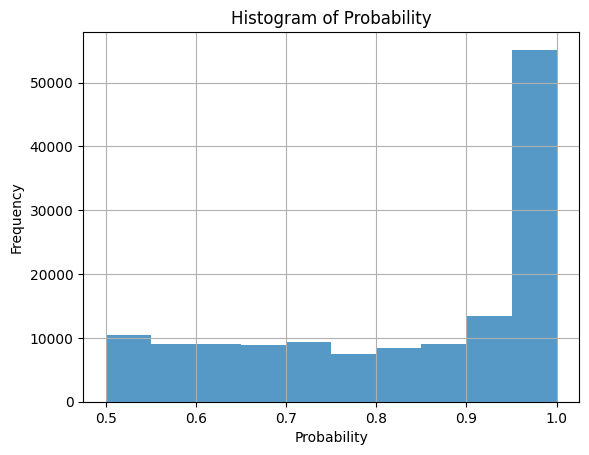

In [32]:
import matplotlib.pyplot as plt

probability_data = true_predict.select('probability').rdd.flatMap(lambda x: x).collect()

plt.hist(probability_data, bins=10, alpha=0.75)
plt.title('Histogram of Probability')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

/tmp/ipykernel_3683467/2960443069.py:6: FutureWarning:                          

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probability_data, shade=True)


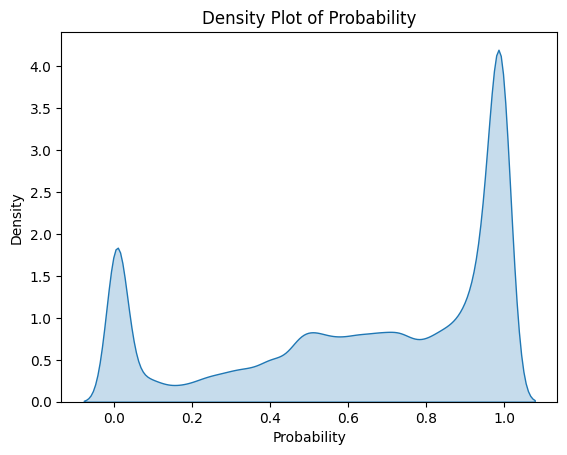

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

probability_data = df_results.select('probability').toPandas()['probability']

sns.kdeplot(probability_data, shade=True)
plt.title('Density Plot of Probability')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.show()

In [24]:
keywords = 'veiculos|automoveis'
filtered_df = df_results.filter(col('domain').rlike(keywords))
filtered_df = filtered_df.orderBy('probability', ascending=False)
filtered_df

domain,html,probability,prediction
minicarveiculos.com.br,"<!DOCTYPE HTML>\n<html lang=""pt-br"">\n<head>\n <meta charset=""UTF-8"">\n\n <...",0.9963919477554694,true
lotusautomoveis.com.br,"<!DOCTYPE html>\n<html lang=""pt"">\n<head>\n \n <meta charset='utf-8'>\n <meta name=""viewport"" ...",0.9909523916292284,true
carvalhoveiculosrs.com.br,"<!doctype html>\r\n<html lang=""pt"">\r\n<head>\r\n <!-- Required meta tags -->\r\n <meta cha...",0.9882405283051917,true
carvalhoveiculosrs.com.br,"<!doctype html>\r\n<html lang=""pt"">\r\n<head>\r\n <!-- Required meta tags -->\r\n <meta cha...",0.9882405283051917,true
marmottaveiculos.com.br,"<!DOCTYPE html>\n<html lang=""pt"">\n<head>\n \n <meta charset='utf-8'>\n <meta name=""viewport"" ...",0.9839371885984873,true
bolsadeautomoveisguacu.com.br,"<!DOCTYPE html>\n<html class=""light-style layout-menu-fixed"" data-theme=""theme-default"" data-asse...",0.978596212745487,true
bolsadeautomoveisguacu.com.br,"<!DOCTYPE html>\n<html class=""light-style layout-menu-fixed"" data-theme=""theme-default"" data-asse...",0.978596212745487,true
bolsadeautomoveisguacu.com.br,"<!DOCTYPE html>\n<html class=""light-style layout-menu-fixed"" data-theme=""theme-default"" data-asse...",0.978596212745487,true
bolsadeautomoveisguacu.com.br,"<!DOCTYPE html>\n<html class=""light-style layout-menu-fixed"" data-theme=""theme-default"" data-asse...",0.978596212745487,true
portaldosveiculoseletricos.com.br,"<!doctype html>\r\n<html dir=""ltr"" lang=""pt-BR"">\r\n<!--Slider Revolution-->\r\n\t<!--[if lt IE 7...",0.9731110004795513,true


# Join with technologies

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, lit, coalesce

probability_window = Window.partitionBy("domain").orderBy(desc("probability"))

df_classification_w_dupes = spark.read.parquet('../data/countries_filtered_with_predictions_v2')

df_classification_window = df_classification_w_dupes.withColumn("row_number", row_number().over(probability_window))

df_classification = df_classification_window.filter(df_classification_window["row_number"] == 1)
df_classification_above_5 = df_classification.filter(df_classification['probability'] > 0.5)


In [4]:
df_classification_above_5 = df_classification_above_5.drop('row_number').drop('html')



In [5]:
df_classification_above_5.write.mode('overwrite').parquet("accounting_website_classifier/data/ecommerce/classified_ecommerces")

In [6]:
test = spark.read.parquet("accounting_website_classifier/data/ecommerce/classified_ecommerces.parquet")
test

domain,probability,prediction
annaminiaturas.com.br,0.84603469524954,true
annavivacqua.com.br,0.9986382539408057,true
anp.com.br,0.7141561031169529,true
antiestaticos.com.br,0.8353835241925087,true
anyboy.com.br,0.9984329152525006,true
anystore.com.br,0.7215837353334924,true
aocloja.com.br,0.9647827571196416,true
aondevocefor.com.br,0.9990827684552835,true
aoss.com.br,0.662521468450525,true
apersonaliza.com.br,0.5883556704981344,true


In [19]:
df_classification_above_5

domain,probability,prediction
anossadrogaria.com.br,0.8296209883030932,true
anpara.org.br,0.6169876846077705,true
antonellafaloni.com.br,0.9553448317954086,true
antoniafontenelleeyewear.com.br,0.9653090629607924,true
antoniettastudio.com.br,0.5566673121734662,true
aoficinacriativa.com.br,0.8381008390702422,true
aoy.com.br,0.7309930682570047,true
apbolsasebrindes.com.br,0.9349363790145111,true
aperio.com.br,0.9122521968807126,true
apkcomercio.com.br,0.9472832579308531,true


In [16]:
ecommerces_by_technology = spark.read.parquet('../../spider-analysis/ecommerces_by_technology')

df_classification_with_source = df_classification.withColumn('source_count_df_classification', lit(1))
ecommerces_by_technology_with_source = ecommerces_by_technology.withColumn('source_count_ecommerces', lit(1))

joined_df = df_classification_with_source.join(ecommerces_by_technology_with_source, on='domain', how='full')

joined_df = joined_df.withColumn('total_occurrences', 
                                 coalesce(col('source_count_df_classification'), lit(0)) + 
                                 coalesce(col('source_count_ecommerces'), lit(0)))

joined_df = joined_df[['domain', 'probability', 'ecommerce_technology', 'technologies', 'total_occurrences']]
joined_df.show()


+--------------------+-----------+--------------------+--------------------+-----------------+
|              domain|probability|ecommerce_technology|        technologies|total_occurrences|
+--------------------+-----------+--------------------+--------------------+-----------------+
|     027kicks.com.br|       NULL|           [SHOPIFY]|[CART FUNCTIONALI...|                1|
|      14print.com.br|       NULL|       [WOOCOMMERCE]|[JQUERY MIGRATE, ...|                1|
|      374pets.com.br|       NULL|           [SHOPIFY]|[SHOPIFY, JQUERY,...|                1|
|       3aenge.com.br|       NULL|       [WOOCOMMERCE]|[APACHE, WOOCOMME...|                1|
|3dlineprofissiona...|       NULL|       [WOOCOMMERCE]|[LITESPEED, WOOCO...|                1|
|     3rimport.com.br|       NULL|       [WOOCOMMERCE]|[JQUERY MIGRATE, ...|                1|
|    3stories1.com.br|       NULL|       [WOOCOMMERCE]|[JQUERY, MYSQL, U...|                1|
|     3zbrasil.com.br|       NULL|       [WOOCOMME

In [17]:
joined_df.count()

154313

In [21]:
from pyspark.sql.functions import col, array

filtered_df = joined_df.filter(col('ecommerce_technology') != array(lit('[CART FUNCTIONALITY]')))

filtered_df.write.parquet('ecommerce_technologies_v2')

24/07/11 17:53:15 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/07/11 17:53:18 WARN DAGScheduler: Broadcasting large task binary with size 1076.0 KiB


In [22]:
filtered_df.count()

24/07/11 17:53:20 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/07/11 17:53:23 WARN DAGScheduler: Broadcasting large task binary with size 1075.8 KiB


109145